# Intro

* Exact computation time: use the system clock. Accurate to sub-milisecond.
* Rough computation time: Use the timer at the left side of cell

# Data

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import time

import matplotlib.pyplot as plt
from IPython import display

In [2]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')
data

array([[6., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [7., 0., 0., ..., 0., 0., 0.],
       ...,
       [2., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [3]:
labels = data[:,0]
data = data[:,1:]

data = torch.tensor(data).float()
labels = torch.tensor(labels).long()

data_norm = data / torch.max(data)
labels.shape, data.shape

(torch.Size([20000]), torch.Size([20000, 784]))

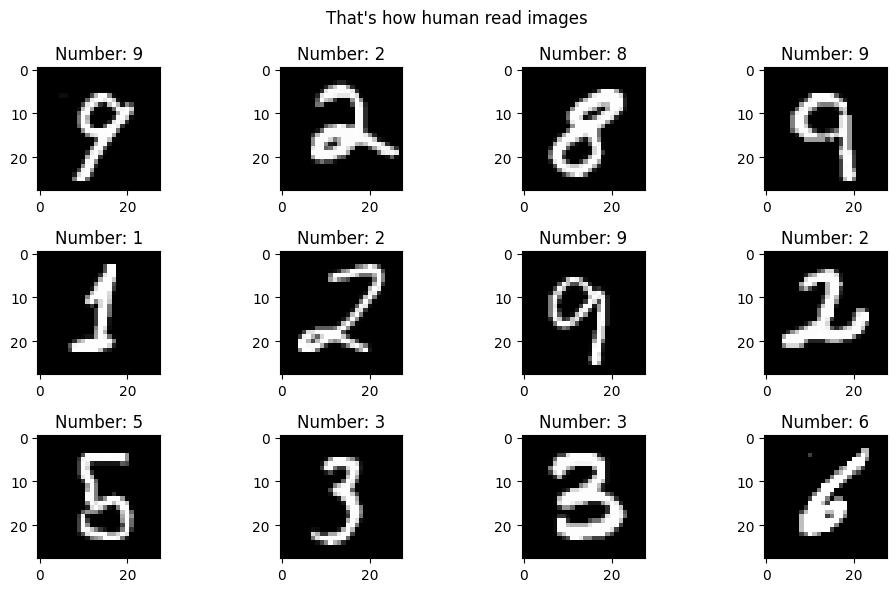

In [4]:
fig, axs = plt.subplots(3,4,figsize = (10, 6))

for ax in axs.flatten():
  random_row = np.random.randint(0, data.shape[0])
  img = torch.reshape(data[random_row], (28,28))

  ax.imshow(img, cmap = 'grey')
  ax.set_title(f'Number: %i' %labels[random_row])

plt.suptitle('That\'s how human read images')
plt.tight_layout()
plt.show()

# Split

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(data_norm, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

# Model

In [6]:
def CreateNet():

  class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784, 128)

      self.fc1 = nn.Linear(128,64)
      self.fc2 = nn.Linear(64,64)

      self.output = nn.Linear(64,10)

    def forward(self, x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.output(x)
      return x

  net = Net()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
  return net, loss_fn, optimizer

CreateNet()

(Net(
   (input): Linear(in_features=784, out_features=128, bias=True)
   (fc1): Linear(in_features=128, out_features=64, bias=True)
   (fc2): Linear(in_features=64, out_features=64, bias=True)
   (output): Linear(in_features=64, out_features=10, bias=True)
 ),
 CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [7]:
net, loss_fn, optimizer = CreateNet()
X, y = next(iter(train_dataloader))
y_hat = net(X)
loss = loss_fn(y_hat, y)
acc = 100 * torch.mean(
    (torch.argmax(y_hat, axis = 1) == y).float()
)
print(f'First spin Accuracy: {acc}% ')

First spin Accuracy: 4.6875% 


# Train

In [8]:
def ModelTrain(epochs, verbose):
  net, loss_fn, optimizer = CreateNet()

  losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []

  time_start = time.process_time()

  for epoch in range(epochs):
    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc = 100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    test_accs.append(test_acc)
  # end epochs
    time_end = time.process_time()
    time_total = time_end - time_start

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Elapsed Time: {time_total:.2f} s | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs, losses

In [9]:
train_acc, test_acc, losses = ModelTrain(50, verbose = True)

Epoch: 0 | Elapsed Time: 0.41 s | Train Acc: 10.69 | Test Acc: 15.10 | Loss: 2.30
Epoch: 10 | Elapsed Time: 5.10 s | Train Acc: 86.59 | Test Acc: 87.03 | Loss: 0.46
Epoch: 20 | Elapsed Time: 9.41 s | Train Acc: 91.29 | Test Acc: 90.47 | Loss: 0.30
Epoch: 30 | Elapsed Time: 13.73 s | Train Acc: 93.58 | Test Acc: 92.68 | Loss: 0.23
Epoch: 40 | Elapsed Time: 19.07 s | Train Acc: 95.40 | Test Acc: 94.00 | Loss: 0.17


# Time Elapsed

In [10]:
time_start = time.process_time()

ModelTrain(80, verbose = True)

time_total = time.process_time() - time_start
print(f'\n\n\nTotal elapsed experiment time: {time_total/60:.2f} minutes')

Epoch: 0 | Elapsed Time: 0.41 s | Train Acc: 13.34 | Test Acc: 17.35 | Loss: 2.30
Epoch: 10 | Elapsed Time: 5.27 s | Train Acc: 85.68 | Test Acc: 85.45 | Loss: 0.49
Epoch: 20 | Elapsed Time: 9.39 s | Train Acc: 91.40 | Test Acc: 90.62 | Loss: 0.30
Epoch: 30 | Elapsed Time: 13.74 s | Train Acc: 93.56 | Test Acc: 92.33 | Loss: 0.22
Epoch: 40 | Elapsed Time: 18.06 s | Train Acc: 95.34 | Test Acc: 93.95 | Loss: 0.17
Epoch: 50 | Elapsed Time: 22.18 s | Train Acc: 96.52 | Test Acc: 94.40 | Loss: 0.13
Epoch: 60 | Elapsed Time: 26.92 s | Train Acc: 97.43 | Test Acc: 94.92 | Loss: 0.10
Epoch: 70 | Elapsed Time: 31.20 s | Train Acc: 98.07 | Test Acc: 95.15 | Loss: 0.08



Total elapsed experiment time: 0.58 minutes


#